In [312]:
import os
import pandas as pd

from qsprpred.data import QSPRDataset
from qsprpred.data import RandomSplit
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.plotting.classification import ROCPlot
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.ensemble import RandomForestClassifier
from qsprpred.models import SklearnModel
from qsprpred.models import CrossValAssessor, TestSetAssessor
from qsprpred.plotting.classification import ROCPlot
from qsprpred.plotting.classification import MetricsPlot
import numpy as np
from qsprpred.models import OptunaOptimization
from qsprpred.models import GridSearchOptimization, CrossValAssessor
from qsprpred.data import BootstrapSplit

In [313]:
cluster_type = 'dis'
cluster_number = 1
receptor = 'Glucocorticoid_receptor'

In [314]:
#active compaunds

dff = pd.read_csv(f"recall_metrics_data/data/{receptor}/IS_{receptor}_with_p_chembl_{cluster_type}_{cluster_number}.csv", header = None, na_values=('NA', 'nan', 'NaN'))
dff = dff.drop([0], axis = 1)
dff.columns = ['SMILES', 'pchembl_value']


In [315]:
dff_non_active = pd.read_csv(f"recall_metrics_data/data/{receptor}/glucocor_recep_neaktiv.csv", header = None)
dff_non_active = dff_non_active.drop([0], axis = 1)
dff_non_active.columns = ['SMILES', 'pchembl_value']
dff_non_active = dff_non_active.reset_index(drop=True)

In [316]:
result = pd.concat([dff, dff_non_active]).reset_index(drop=True)
result

,SMILES,pchembl_value
0,C[C@H]1C[C@@H]2[C@H]3CCC4=CC(=O)C=C[C@@]4(C)[C...,7.850
1,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,7.940
2,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,8.360
3,C[C@]12CCC(=O)C=C1CC[C@H]1[C@@H]3CC[C@](O)(C(=...,8.035
4,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,8.240
...,...,...
1941,COC(=O)C(c1ccc(Cl)cc1Cl)n1ccc2c(NS(C)(=O)=O)cc...,5.230
1942,COC(=O)C(c1ccc(F)cc1Cl)n1ccc2c(NS(C)(=O)=O)cccc21,5.500
1943,CN1CCC(Oc2ccc(N3C(=S)N(c4cnc(C#N)c(C(F)(F)F)c4...,4.700
1944,CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...,4.540


In [317]:
## Filter incorrect SMILES
working_rows = []
for index, row in result.iterrows():
    try:
        mol = Chem.MolFromSmiles(row['SMILES'])
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        working_rows.append(row)
    except: 
        print(f'removed: {index}')

df_clean = pd.DataFrame(working_rows)

In [318]:
## Working directory:
DATA_PATH_QSAR = f"project_recall_metrics/recall_metrics/data/{receptor}/qsar"
os.makedirs(DATA_PATH_QSAR, exist_ok=True)


## set QSPRDataset
dataset = QSPRDataset(
    name=f"{receptor}_{cluster_type}_{cluster_number}",
    df=df_clean,  
    target_props=[{"name" : "pchembl_value", "task" : "SINGLECLASS", "th": [6.5]}], 
    store_dir=DATA_PATH_QSAR,
)
# Specifiy random split for creating the train (80%) and test set (20%) da se zamenit na scfaffold split nebo jeste jiny!!
rand_split = RandomSplit(test_fraction=0.2, dataset=dataset)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculators=[MorganFP(radius=3, nBits=2048)],
)


print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}, {len(dataset.y_ind) / len(dataset.df) * 100}%")


Number of samples train set: 1556
Number of samples test set: 390, 20.041109969167522%


In [319]:
# hyperparameter search


params = {
    'n_estimators' : [50, 250, 500, 1000],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    "n_jobs": [1]
}
# Learn model
model = SklearnModel(
    base_dir=DATA_PATH_QSAR,
    name=f"Glucocorticoid_{cluster_type}_{cluster_number}_RandomForestClassifier",
    alg = RandomForestClassifier
)

#score_func = SklearnMetric.getDefaultMetric(model.task)
gridsearcher = GridSearchOptimization(
    model_assessor=CrossValAssessor(scoring='r2'),
    param_grid=params,
    score_aggregation=np.median)
print(gridsearcher.optimize(model, dataset))





{'criterion': 'entropy', 'n_estimators': 50, 'n_jobs': 1}


In [320]:
model.parameters

{'random_state': 4078700231,
 'criterion': 'entropy',
 'n_estimators': 50,
 'n_jobs': 1}

In [321]:
# We can now assess the model performance on the training set using cross validation
CrossValAssessor("roc_auc_ovr")(model, dataset)

# and on the test set
TestSetAssessor("roc_auc_ovr")(model, dataset)


# Finally, we need to fit the model on the complete dataset if we want to use it further
model.fitDataset(dataset)

'/home/filv/phd_projects/iga_2023/drugex/DrugEx/tutorial/project_recall_metrics/recall_metrics/data/Glucocorticoid_receptor/qsar/Glucocorticoid_dis_1_RandomForestClassifier/Glucocorticoid_dis_1_RandomForestClassifier_meta.json'

In [322]:
summary

,Model,Fold,Property,accuracy,precision,recall,f1,matthews_corrcoef,calibration_error,roc_auc,Class,Set
0,Glucocorticoid_dis_0_RandomForestClassifier,0.0,pchembl_value,0.816054,0.826667,0.810458,0.818482,0.632206,0.068545,0.884658,Binary,Cross Validation
1,Glucocorticoid_dis_0_RandomForestClassifier,1.0,pchembl_value,0.825503,0.877551,0.791411,0.832258,0.655225,0.038775,0.915087,Binary,Cross Validation
2,Glucocorticoid_dis_0_RandomForestClassifier,2.0,pchembl_value,0.872483,0.883562,0.860000,0.871622,0.745269,0.067550,0.927500,Binary,Cross Validation
3,Glucocorticoid_dis_0_RandomForestClassifier,3.0,pchembl_value,0.838926,0.832168,0.832168,0.832168,0.677329,0.044842,0.922896,Binary,Cross Validation
4,Glucocorticoid_dis_0_RandomForestClassifier,4.0,pchembl_value,0.835570,0.885714,0.789809,0.835017,0.676594,0.034125,0.921737,Binary,Cross Validation
5,Glucocorticoid_dis_0_RandomForestClassifier,Independent Test,pchembl_value,0.839142,0.842391,0.833333,0.837838,0.678312,0.047900,0.909105,Binary,Independent Test


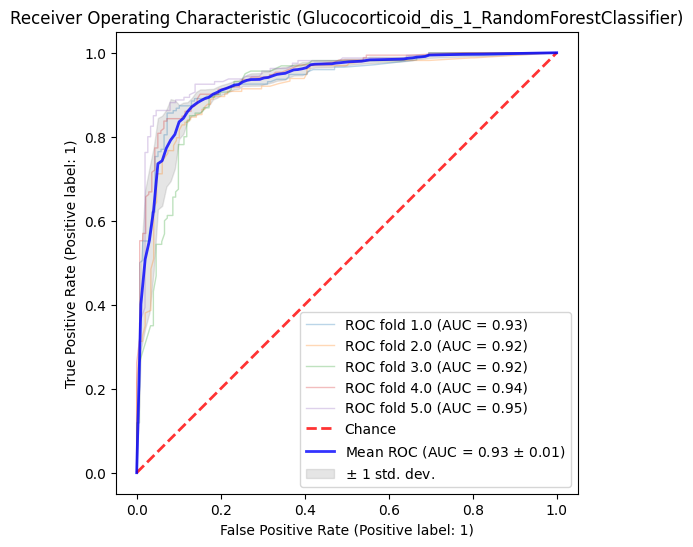

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [323]:

# plot the results for bootstrapping
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot([model])
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

In [324]:
sample_inputs = [
    'C[C@H]1C[C@@H]2[C@H]3CCC4=CC(=O)C=C[C@@]4(C)[C@]3(F)[C@H](O)C[C@@]2(C)[C@]1(O)C(=O)CSCCNC(=S)NCCNC(=O)c1cc(NC(=O)c2cc(NC(=O)c3nccn3C)cn2C)cn1C', # p_chemble_value 7.85
    'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@H]3[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)CSc1nc2ccccc2o1' # p_chemble_value 8.36
]

In [325]:
from qsprpred.models import SklearnModel

predictor = SklearnModel(
    name=f'Glucocorticoid_{cluster_type}_{cluster_number}_RandomForestClassifier',
    base_dir=DATA_PATH_QSAR,
)

predictor.predictMols(sample_inputs, use_probas=True)

[array([[0.1 , 0.9 ],
        [0.01, 0.99]])]